In [1]:
import numpy as np
import pandas as pd
import scipy.io
from os.path import join as pjoin
from sklearn.model_selection import KFold

def get_data(subject, training, PATH):
    # pats_ids_in, loadpath, n_chans_all = 64, tlim = [-1, 1], event_types = ['']
    '''
    Loads the dataset 2a of the BCI Competition IV

    Arguments:
    subject -- number of subjects in [1, ..., 9]
    training -- if True, load training data
                if False, load testing data

    Return: data -- numpy matrix, size = N0_valid _trial x 22 x 1750
            class -- numpy matrix, size = NO_valid_trial 

    '''
    
    numChannels = 22 # arguments?
    numTrials = 6*48
    lengthWindow = 7*250 

    class_return = np.zeros(numTrials)
    data_return = np.zeros((numTrials, numChannels, lengthWindow))

    numValidTrial = 0

    trainPath = PATH + 'train/'
    testPath = PATH + 'test/'

    if training:
        a = scipy.io.loadmat(trainPath+'A0'+str(subject)+'T.mat')
    else:
        a = scipy.io.loadmat(testPath+'A0'+str(subject)+'E.mat')

    a_data = a['data']

    for i in range(0, a_data.size):
        a_data1 = a_data[0, i]
        a_data2 = [a_data1[0, 0]]
        a_data3 = a_data2[0]
        
        a_X         = a_data3[0] 
        a_trial     = a_data3[1] # sbj 0, 1 is empty. 
        a_y         = a_data3[2] # 1: left hand, 2: right hand, 3: feet, 4: tongue
        a_fs        = a_data3[3] # 250 Hz
        a_classes   = a_data3[4] # a_classes[0][0] = 'left hand'
        a_artifacts = a_data3[5] 
        a_gender    = a_data3[6] # not necessary
        a_age       = a_data3[7] # not necessary 

        for trial in range(0, a_trial.size):
            if(a_artifacts[trial] == 0):
                data_return[numValidTrial, :, :] = np.transpose(a_X[int(a_trial[trial]):(int(a_trial[trial])+lengthWindow) , :22])
                class_return[numValidTrial] = int(a_y[trial])
                numValidTrial += 1

    return data_return[0:numValidTrial, :, :], class_return[0:numValidTrial]


In [2]:
class Accumulator:  #@save
    """在`n`个变量上累加。"""
    def __init__(self, n):
        self.data = [0.0] * n

    def add(self, *args):
        self.data = [a + float(b) for a, b in zip(self.data, args)]

    def reset(self):
        self.data = [0.0] * len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

In [3]:
from IPython import display
from d2l import torch as d2l 

class Animator:  #@save
    """在动画中绘制数据。"""
    def __init__(self, xlabel=None, ylabel=None, legend=None, xlim=None,
                 ylim=None, xscale='linear', yscale='linear',
                 fmts=('-', 'm--', 'g-.', 'r:'), nrows=1, ncols=1,
                 figsize=(3.5, 2.5)):
        # 增量地绘制多条线
        if legend is None:
            legend = []
        d2l.use_svg_display()
        self.fig, self.axes = d2l.plt.subplots(nrows, ncols, figsize=figsize)
        if nrows * ncols == 1:
            self.axes = [self.axes,]
        # 使用lambda函数捕获参数
        self.config_axes = lambda: d2l.set_axes(self.axes[
            0], xlabel, ylabel, xlim, ylim, xscale, yscale, legend)
        self.X, self.Y, self.fmts = None, None, fmts

    def add(self, x, y):
        # 向图表中添加多个数据点
        if not hasattr(y, "__len__"):
            y = [y]
        n = len(y)
        if not hasattr(x, "__len__"):
            x = [x] * n
        if not self.X:
            self.X = [[] for _ in range(n)]
        if not self.Y:
            self.Y = [[] for _ in range(n)]
        for i, (a, b) in enumerate(zip(x, y)):
            if a is not None and b is not None:
                self.X[i].append(a)
                self.Y[i].append(b)
        self.axes[0].cla()
        for x, y, fmt in zip(self.X, self.Y, self.fmts):
            self.axes[0].plot(x, y, fmt)
        self.config_axes()
        display.display(self.fig)
        display.clear_output(wait=True)

In [4]:
import torch
from braindecode.models.deep4 import Deep4Net
from torch import nn
from braindecode.torch_ext.util import set_random_seeds
from braindecode.datautil.signal_target import SignalAndTarget
from braindecode.torch_ext.optimizers import AdamW
from braindecode.torch_ext.schedulers import ScheduledOptimizer, CosineAnnealing
from braindecode.datautil.iterators import get_balanced_batches
from numpy.random import RandomState
from braindecode.torch_ext.util import np_to_var, var_to_np
import torch.nn.functional as F

In [18]:
def load_multiple_data(batch_size):
    sbjs = [1, 2, 3, 4, 5, 6, 7, 8, 9] 
    fold = 1

    test_subj = sbjs[fold]
    cv_set = np.array(sbjs[fold+1:]+sbjs[:fold])
    kf = KFold(n_splits=6)

    for cv_index, (train_index, test_index) in enumerate(kf.split(cv_set)):
        train_subjs = cv_set[train_index]
        valid_subjs = cv_set[test_index]

        #get_data(subject, training, PATH)

        train_set, train_label = get_data()

In [5]:
def load_single_data(subject, crossvalidation, path):
    if crossvalidation:
        X, Y = get_data(subject, True, path)
        kf = KFold(n_splits=5)
        #input_time_length = 450

        for train_index, valid_index in kf.split(X):
            X_train = X[train_index].astype(np.float32)
            Y_train = Y[train_index]
            Y_train = np.array([int(label)-1 for label in Y_train])
            Y_train = Y_train.astype(np.int64)
            train_set = SignalAndTarget(X_train, Y_train)

            X_val = X[valid_index].astype(np.float32)
            Y_val = Y[valid_index]
            Y_val = np.array([int(label)-1 for label in Y_val])
            Y_val = Y_val.astype(np.int64)
            valid_set = SignalAndTarget(X_val, Y_val)

        return train_set, valid_set
        # return data.DataLoader 
    
    else:
        X_test, Y_test = get_data(subject, crossvalidation, path)
        X_test = X_test.astype(np.float32)
        Y_test = np.array([int(label)-1 for label in Y_test])
        Y_test = Y_test.astype(np.int64)
        test_set = SignalAndTarget(X_test, Y_test)

        return test_set

In [6]:
datapath = '/home/xinjie/xinjie/IV-2a/BCIIV2a_dataset/'
subject = 1

train_set, valid_set = load_single_data(subject=subject, 
                                        crossvalidation=True, 
                                        path=datapath)
test_set = load_single_data(subject=subject, 
                            crossvalidation=False, 
                            path=datapath)

In [7]:
print(train_set.X.shape)
print(valid_set.X.shape)
print(test_set.X.shape)

(219, 22, 1750)
(54, 22, 1750)
(281, 22, 1750)


In [19]:
# Create the model 

from braindecode.models.deep4 import Deep4Net
from torch import nn
from braindecode.torch_ext.util import set_random_seeds
from braindecode.models.util import to_dense_prediction_model

cuda = True
#cuda = False
set_random_seeds(seed=20211027, cuda=cuda)

input_time_length = 450
n_classes = 4
in_chans = train_set.X.shape[1]
#print(in_chans)
model = Deep4Net(in_chans=in_chans, n_classes=n_classes, 
                 input_time_length=input_time_length, final_conv_length='auto').create_network()

to_dense_prediction_model(model)
if cuda:
    model.cuda()

In [8]:
from braindecode.datautil.iterators import CropsFromTrialsIterator

def get_iterator(net, dataset, batch_size, input_time_length):
    in_chans = dataset.X.shape[1]

    test_input = np_to_var(np.ones((2, in_chans, input_time_length, 1), dtype=np.float32))
    if cuda:
        test_input = test_input.cuda()

    out = net(test_input)
    n_preds_per_input = out.cpu().data.numpy().shape[2]
    iterator = CropsFromTrialsIterator(batch_size=batch_size, 
                                       input_time_length=input_time_length, 
                                       n_preds_per_input=n_preds_per_input)
    
    return iterator

In [9]:
iterator = get_iterator(model, train_set, 16, input_time_length)

In [22]:
rng = RandomState((2021, 10, 27))

optimizer = AdamW(model.parameters(), lr=1*0.01, weight_decay=0.5*0.001)
#n_epochs = 30
n_epochs = 100
n_updates_per_epoch = len([None for b in iterator.get_batches(train_set, True)])
scheduler = CosineAnnealing(n_epochs * n_updates_per_epoch)
optimizer = ScheduledOptimizer(scheduler, optimizer, schedule_weight_decay=True)

In [11]:
def accuracy(y_hat, y):
    if len(y_hat.shape) > 1 and y_hat.shape[1] > 1:
        y_hat = y_hat.argmax(axis=1)
    cmp = y_hat.type(y.dtype) == y
    return float(cmp.type(y.dtype).sum())

In [12]:
def train_epoch(net, iterator, dataset, optimizer):
    if isinstance(net, torch.nn.Module):
        net.train()
    
    metric = Accumulator(3)

    for X, y in iterator.get_batches(dataset, shuffle=True):
        net_in = torch.tensor(X, dtype=torch.float32)
        if cuda:
            net_in = net_in.cuda()
        
        net_target = torch.tensor(y)
        if cuda:
            net_target = net_target.cuda()

        optimizer.zero_grad()
        y_hat = net(net_in)
        y_hat = torch.mean(y_hat, dim=2, keepdim=False)

        loss = F.nll_loss(y_hat, net_target)
        loss.backward()
        optimizer.step()

        metric.add(float(loss.sum()), accuracy(y_hat, net_target), net_target.numel())
    
    # train loss, train accuracy 
    return metric[0]/metric[2], metric[1]/metric[2]


In [13]:
from braindecode.experiments.monitors import compute_preds_per_trial_from_crops

def evaluate_accuracy(net, iterator, setname, dataset):
    net.eval()
    #metric = Accumulator(2)

    all_preds = []
    all_losses = []
    batch_sizes = []

    for batch_X, batch_y in iterator.get_batches(dataset, shuffle=False):
        net_in = torch.tensor(batch_X, dtype=torch.float32)
        if cuda:
            net_in = net_in.cuda()
            
        net_target = torch.tensor(batch_y)
        if cuda:
            net_target = net_target.cuda()
            
        y_hat = net(net_in)
        all_preds.append(var_to_np(y_hat))

        y_hat = torch.mean(y_hat, dim=2, keepdim=False)
        loss = F.nll_loss(y_hat, net_target)
        loss = float(var_to_np(loss))

        all_losses.append(loss)
        batch_sizes.append(len(batch_X))
    
    loss = np.mean(np.array(all_losses) * np.array(batch_sizes) / np.mean(batch_sizes))
    print("{:6s} Loss: {:.5f}".format(setname, loss))

    preds_per_trial = compute_preds_per_trial_from_crops(all_preds, input_time_length, dataset.X)

    meaned_preds_per_trial = np.array([np.mean(p, axis=1) for p in preds_per_trial])
    predicted_labels = np.argmax(meaned_preds_per_trial, axis=1)
    acc = np.mean(predicted_labels == dataset.y)
    print("{:6s} Accuracy: {:.1f}%".format(setname, acc * 100))
    
    return acc

In [14]:
def train(net, iterator, input_time_length, train_set, valid_set, num_epochs, optimizer):
    animator = Animator(xlabel='epoch', xlim=[1, num_epochs], ylim=[0.0, 1.0],
                        legend=['train loss','train acc', 'test acc'])
    
    #animator2 = Animator(xlabel='epoch', xlim=[1, num_epochs], ylim=[0.0, 1.0],
    #                    legend=['train loss'])

    for epoch in range(num_epochs):
        train_metrics = train_epoch(net, iterator, train_set, optimizer)
        print("{:6s} Loss: {:.5f}".format('Train', train_metrics[0]))
        print("{:6s} Accuracy: {:.5f}".format('Train', train_metrics[1]))

        #for setname, dataset in (('Train', train_set), ('Valid', valid_set)):
        valid_acc = evaluate_accuracy(net, iterator, 'Valid', valid_set)
    
        animator.add(epoch+1, train_metrics + (valid_acc,))
        #animator.add(epoch+1, train_metrics)
    
    train_loss, train_acc = train_metrics
    
    assert train_loss < 0.5, train_loss
    assert train_acc <= 1 and train_acc > 0.3, train_acc
    assert valid_acc <= 1 and valid_acc > 0.3, valid_acc

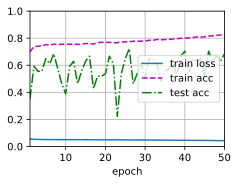

In [23]:
num_epochs = 50

train(model, iterator, input_time_length, train_set, valid_set, num_epochs, optimizer)

In [21]:
evaluate_accuracy(model, iterator, 'Test', test_set)

Test   Loss: 1.10189
Test   Accuracy: 74.0%


74.02135231316726